In [1]:
# loading necessary libraries 

import wget
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#@ Downloading the dataset using wget

wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv")

'AER_credit_card_data.csv'

In [3]:
#@ loading the dataset

data = pd.read_csv('AER_credit_card_data.csv')

data.sample(5)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
29,yes,0,40.00000,5.5000,0.334460,1532.77300,yes,no,4,74,1,19
109,yes,0,43.66667,10.0393,0.021863,182.82500,yes,no,1,12,1,18
480,yes,0,34.83333,2.7500,0.033149,75.63417,yes,no,0,151,1,11
1036,yes,0,26.50000,2.6000,0.110648,239.48670,yes,no,0,12,1,13
401,yes,0,35.25000,3.7000,0.122152,376.63420,yes,no,1,12,1,0


# Data Exploration

In [4]:
data.shape

(1319, 12)

In [5]:
data.duplicated().sum()

0

In [6]:
data.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [7]:
data.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

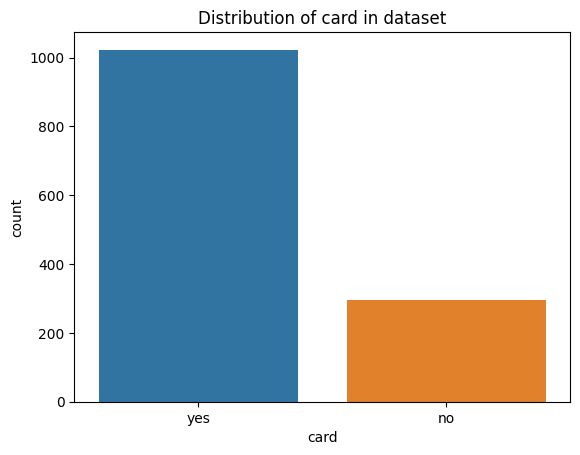

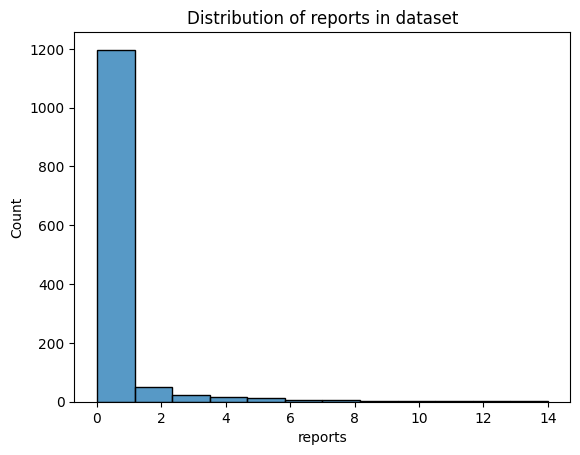

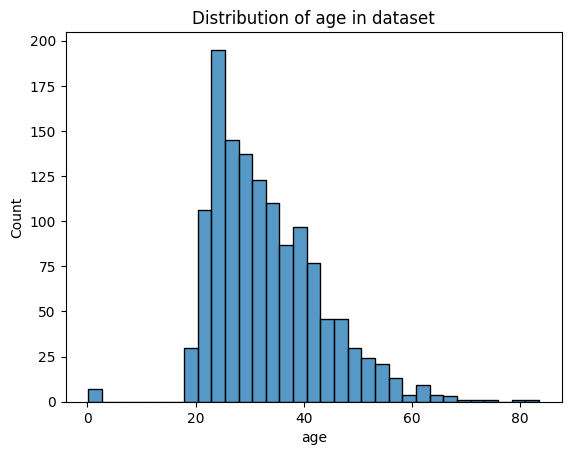

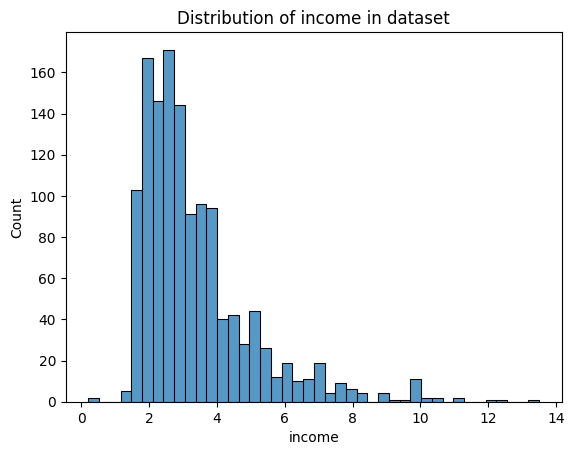

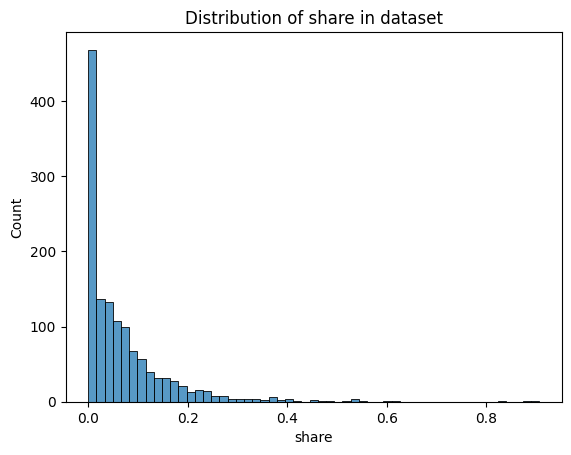

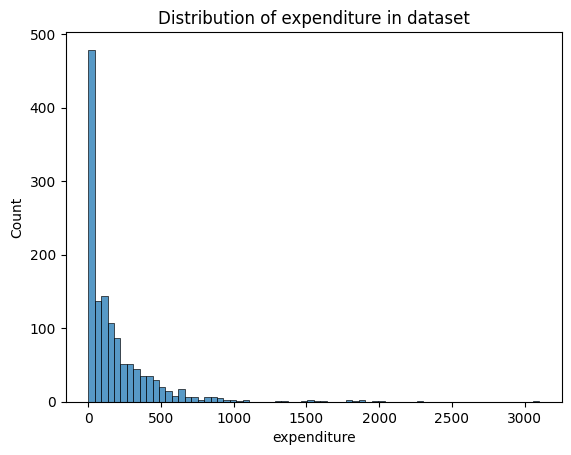

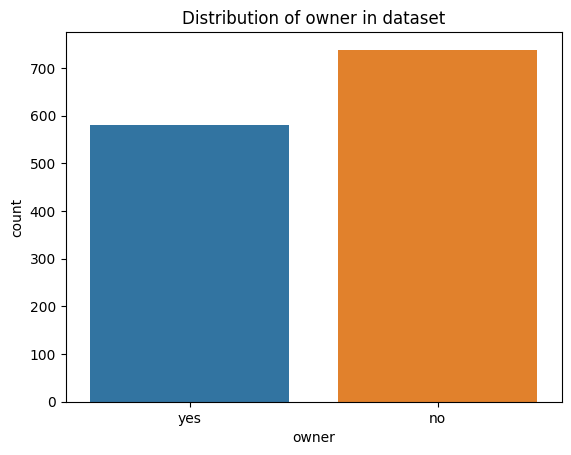

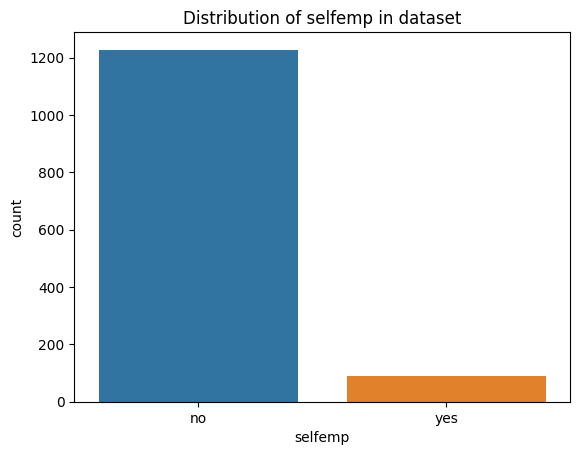

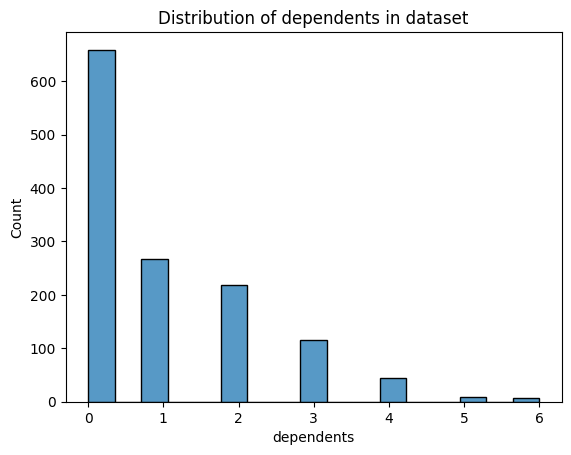

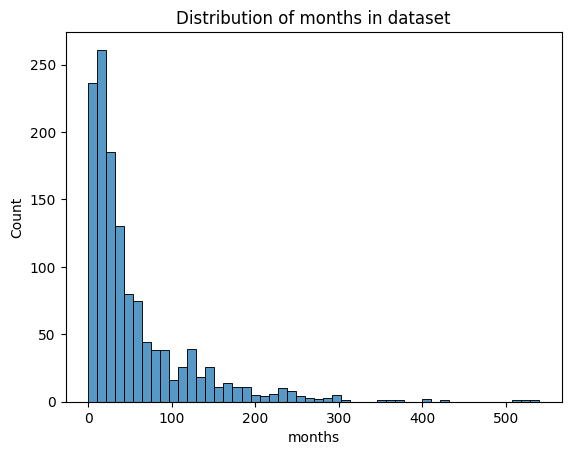

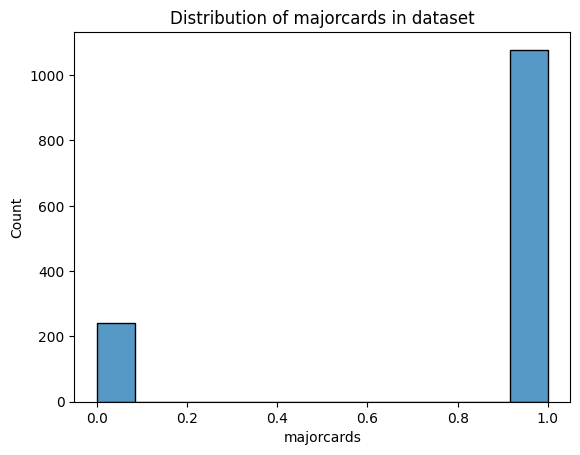

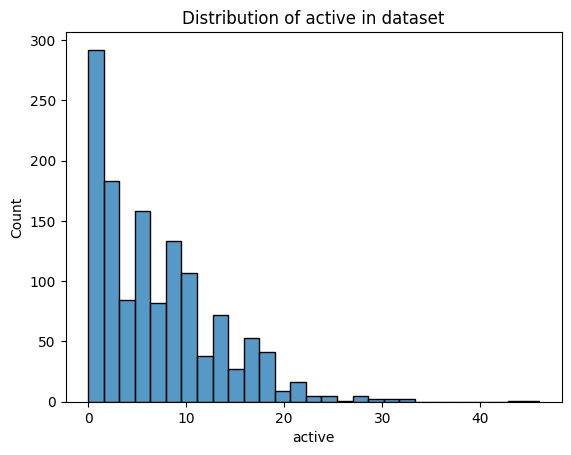

In [8]:
for col in data.columns:
    if data[col].dtype == 'int64'or data[col].dtype == 'float64':
        sns.histplot(data= data , x = col)
        plt.title(f"Distribution of {col} in dataset")
        plt.show()

    else:
        sns.countplot(data=data, x=col)
        plt.title(f"Distribution of {col} in dataset")
        plt.show()

    

From preliminary exploration of the data:

* There are 12 features and 1319 records in the dataset
* There are no duplicates in the dataset
* There are three features with data type object and the other 9 features are numerical
* There are no missing values in the dataset
* Most of the records in dataset use card during transaction
* Some columns/features data types were incorrectly read as numerical rather than categorical - e.g reports, dependents and majorcards
* There is an outlier in the age feature with someones aged 0 

The goal of this homework is to inspect different evaluation metrics .. so on to that!

# Data Preparation

* Create the target variable by mapping yes to 1 and no to 0.
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [9]:
# Mapping the target variable
target = 'card'

data[target] = (data[target] == 'yes').astype('int')

In [10]:
data[target].value_counts()

1    1023
0     296
Name: card, dtype: int64

In [11]:
# splitting the dataset

X = data.drop(columns = [target])
y = data[target]

print(X.shape, y.shape)

(1319, 11) (1319,)


In [12]:
from sklearn.model_selection import train_test_split

X_full_train, X_test, y_full_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size = 0.25, random_state = 1)

X_train.shape, X_val.shape,X_test.shape

((791, 11), (264, 11), (264, 11))

In [13]:

y_train.shape, y_val.shape,y_test.shape

((791,), (264,), (264,))

In [14]:
y_full_train.shape

(1055,)

# Question 1

* ROC AUC could also be used to evaluate feature importance of numerical variables.

*Let's do that*

* For each numerical variable, use it as score and compute AUC with the card variable.
* Use the training dataset for that.

In [15]:
numerical_columns = [col for col in X_train.columns if X_train[col].dtype == 'int64'or X_train[col].dtype == 'float64' ]

numerical_columns

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [16]:
from sklearn.metrics import roc_auc_score

roc_auc = []
for feature in numerical_columns:
    auc_score = roc_auc_score(y_train, X_train[feature])

    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -X_train[feature])

    print('%12s : %.3f'%(feature, auc_score))


     reports : 0.717
         age : 0.524
      income : 0.591
       share : 0.989
 expenditure : 0.991
  dependents : 0.533
      months : 0.529
  majorcards : 0.534
      active : 0.604


## Training the Model

* From now on, use these columns only:

* ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
* Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [17]:
features_used = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

X_train_new = X_train[features_used]
X_val_new = X_val[features_used]

X_train_new.sample()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner,selfemp
39,0,27.75,4.6,0.105744,405.3517,4,28,1,13,yes,no


In [18]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse = False)

dictXtrain_new = X_train_new.to_dict(orient='records')
dictXval_new = X_val_new.to_dict(orient='records')

X_train_enc = dv.fit_transform(dictXtrain_new)
X_val_enc = dv.transform(dictXval_new)



In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train_enc,y_train)

y_pred = model.predict_proba(X_val_enc)[:,1]

# Question 2

* What's the AUC of this model on the validation dataset? (round to 3 digits)

In [20]:

model_auc_score = round(roc_auc_score(y_val,y_pred),3)

print(model_auc_score)

0.995


AUC score of the model is 0.995

# Question 3

*Now let's compute precision and recall for our model.*

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [41]:
from sklearn.metrics import precision_score, recall_score
thresholds = np.arange(0,1.01,0.01)
precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_t = (y_pred >= t).astype('int')
    precision = precision_score(y_val,y_pred_t)
    recall = recall_score(y_val,y_pred_t)
    
    precision_scores.append(precision)
    recall_scores.append(recall)


In [42]:
dict_scores = {}

dict_scores['thresholds'] = thresholds
dict_scores['precision'] = precision_scores
dict_scores['recall'] = recall_scores

df_scores = pd.DataFrame(dict_scores)
df_scores[::10]


,thresholds,precision,recall
0,0.0,0.799242,1.000000
10,0.1,0.925110,0.995261
20,0.2,0.976415,0.981043
30,0.3,0.976190,0.971564
40,0.4,0.995146,0.971564
50,0.5,0.995122,0.966825
60,0.6,0.995122,0.966825
70,0.7,0.995122,0.966825
80,0.8,0.995122,0.966825
90,0.9,1.000000,0.966825


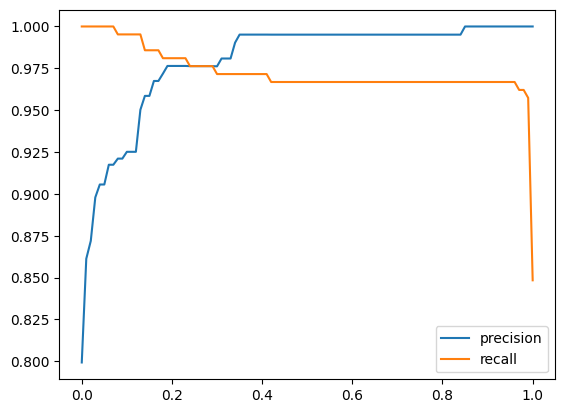

In [43]:
plt.plot(df_scores['thresholds'],df_scores['precision'],label='precision')
plt.plot(df_scores['thresholds'],df_scores['recall'],label='recall')
plt.legend();

*At which threshold precision and recall curves intersect?*

In [32]:
for x in df_scores.iterrows():
    if x[1][1] == x[1][2]:
        print(x[1][0])

0.24
0.25
0.26
0.27
0.28
0.29


# Question 4

*Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both*

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [45]:
from sklearn.metrics import f1_score

thresholds = np.arange(0,1.01,0.01)
f1_scores = []


for t in thresholds:
    y_pred_t = (y_pred >= t).astype('int')
    f1 = f1_score(y_val,y_pred_t)
    
    f1_scores.append(f1)

In [46]:
dict_f1scores = {}

dict_f1scores['thresholds'] = thresholds
dict_f1scores['f1'] = f1_scores


df_f1scores = pd.DataFrame(dict_f1scores)
df_f1scores[::10]


,thresholds,f1
0,0.0,0.888421
10,0.1,0.958904
20,0.2,0.978723
30,0.3,0.973872
40,0.4,0.983213
50,0.5,0.980769
60,0.6,0.980769
70,0.7,0.980769
80,0.8,0.980769
90,0.9,0.983133


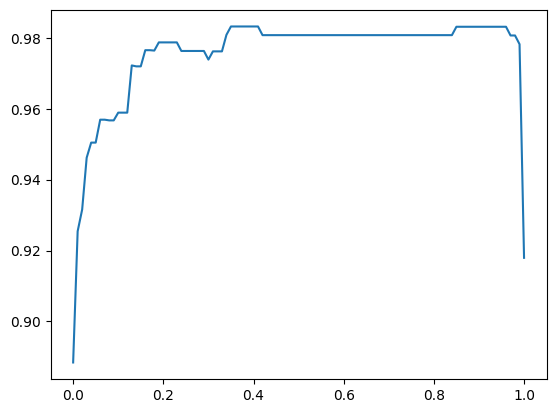

In [47]:
plt.plot(df_f1scores['thresholds'],df_f1scores['f1'])

*At which threshold F1 is maximal?*

In [49]:
maximal_f1 = max(df_f1scores['f1'])

In [53]:
df_f1scores[df_f1scores['f1'] == maximal_f1]

,thresholds,f1
35,0.35,0.983213
36,0.36,0.983213
37,0.37,0.983213
38,0.38,0.983213
39,0.39,0.983213
40,0.40,0.983213
41,0.41,0.983213


# Question 5

* Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

    * KFold(n_splits=5, shuffle=True, random_state=1)
    * Iterate over different folds of df_full_train
    * Split the data into train and validation
    * Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    * Use AUC to evaluate the model on validation

*How large is standard devidation of the AUC scores across different folds?*

In [55]:
from sklearn.model_selection import KFold

In [54]:
df_full_train = pd.concat([X_full_train , y_full_train],axis = 1)

In [84]:
def train(df_train, y_train, C=1.0):
    dict_dfTrain = df_train[features_used].to_dict(orient='records')

    
    X_train = dv.fit_transform(dict_dfTrain)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [87]:
def predict(df_val, dv, model):
    dict_dfVal = df_val[features_used].to_dict(orient='records')

    X_val = dv.transform(dict_dfVal)
    y_pred = model.predict_proba(X_val)[:, 1]

    return y_pred

In [90]:
from tqdm.auto import tqdm
auc_scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_index, val_index in tqdm(kfold.split(df_full_train)):
    
    df_train = df_full_train.iloc[train_index]
    df_val = df_full_train.iloc[val_index]

    y_train = df_train[target]
    y_val = df_val[target]

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

print('%.3f +- %.3f' % (np.mean(auc_scores), np.std(auc_scores)))

5it [00:00, 11.40it/s]

0.996 +- 0.003


# Question 6

* Now let's use 5-Fold cross-validation to find the best parameter C

    * Iterate over the following C values: [0.01, 0.1, 1, 10]
    * Initialize KFold with the same parameters as previously
    * Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    * Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

*Which C leads to the best mean score?*

In [94]:
for c in [0.01, 0.1, 1, 10]: 
    auc_scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_index, val_index in tqdm(kfold.split(df_full_train)):
        
        df_train = df_full_train.iloc[train_index]
        df_val = df_full_train.iloc[val_index]

        y_train = df_train[target]
        y_val = df_val[target]

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    print('C  = %5s, %.3f +- %.3f' % (c,np.mean(auc_scores), np.std(auc_scores)))
        

5it [00:00, 13.58it/s]


C  =  0.01, 0.996 +- 0.003


5it [00:00, 15.38it/s]


C  =   0.1, 0.996 +- 0.003


5it [00:00, 13.22it/s]


C  =     1, 0.996 +- 0.003


5it [00:00, 12.33it/s]

C  =    10, 0.996 +- 0.003
